# Fitting of two Gaussians on a peptide during refolding

One peptide (residue 24-42, one charged state) is extracted from DynamX (identified using PLGS) at each refolding timepoint to fit two single gaussian curve over the bimodal isotope distribution to define the fraction fo the folded (left) and unfolded (right) peak

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from symfit import Variable, Parameter, parameters, Fit, exp, pi, sqrt
from symfit.distributions import Gaussian
from symfit.core.models import CallableModel

from functools import reduce
from operator import add


In [2]:
df = pd.read_excel("peptide 24_42_4Cfolding_ppiA.xlsx", skiprows=[0, 1], header=[0])
df = df.dropna(how='any')

#Making a library with indexes
series_dict = {}
for i, col in enumerate(df):
    if i % 2 == 0:
        idx = df.iloc[:, i]
        data = df.iloc[:, i + 1]
        data.index = idx
        data /= np.trapz(data, data.index)

        series_dict[data.name] = data

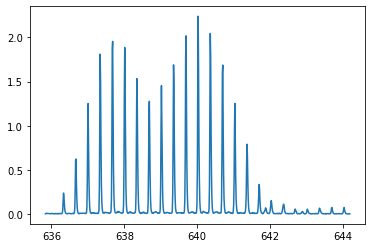

In [3]:
#Selection of one timepoint to fit gaussian
s = series_dict['20sec_1']
fig, ax = plt.subplots()
ax.plot(s.index, s)


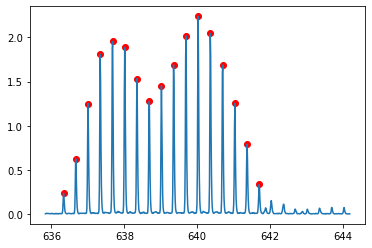

In [4]:
# Selection of peaks with the tops indicated
idx = find_peaks(s, prominence=0.2)[0]

xp = s.index.to_numpy()[idx]
yp = s.to_numpy()[idx]

fig, ax = plt.subplots()
ax.plot(s.index, s)
ax.scatter(xp, yp, color='r')

In [5]:
# initial guesses for the average with equal distance from the middle
# optional: otsu thds
n = 2
vals =np.linspace(xp.min(), xp.max(), num=2*n+1, endpoint=True)
x_pos = vals[1::2]
x_sig = 2*np.diff(xp).mean()
amp = [yp[np.argmin(np.abs(_x - xp))] for _x in x_pos]

In [6]:
# Description of gaussian curve to data
x_var = Variable('x')
y_var = Variable('y')

guassians = []
for i in range(n):
    print(i)
    a_par, mu_par, sig_par = parameters(f'a_{i} mu_{i} sigma_{i}')
    a_par.value = amp[i]
    mu_par.value = x_pos[i]
    sig_par.value = x_sig

    gauss = a_par*exp(-(x_var - mu_par)**2/(2*sig_par**2))
    guassians.append(gauss)

0
1


In [7]:
model = CallableModel({y_var: reduce(add, guassians)})
model


In [8]:
# Fitting of gaussian curve to data
fit = Fit(model, x=xp, y=yp)
fit_result = fit.execute()
print(fit_result)

Scalar Parameters:
Parameter | Value       | Standard Deviation
a_0         1.950490e+00  None
a_1         2.197082e+00  None
mu_0        6.376564e+02  None
mu_1        6.400436e+02  None
sigma_0     6.646178e-01  None
sigma_1     9.060345e-01  None
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   12
Objective              <symfit.core.objectives.LeastSquares object at 0x0000025C92E2E978>
Minimizer              <symfit.core.minimizers.BFGS object at 0x0000025C92E37780>

Goodness of fit qualifiers:
chi_squared            0.02794813074582147
objective_value        0.013974065372910734
r_squared              0.9952825894099139


In [9]:
# Plotting the fit on a figure with good resolution (with x 100 steps)
x_vec = np.linspace(s.index.min(), s.index.max(), num=100, endpoint=True)
y_vec = model(x=x_vec, **fit_result.params)

3.239230443465182
4.989754517391782


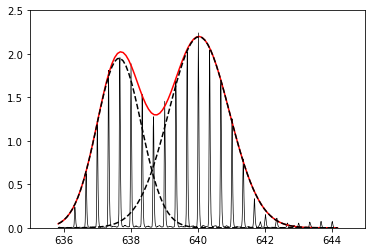

In [10]:
fig, ax = plt.subplots()
ax.plot(s.index, s, color='k',linewidth=0.7)
#ax.scatter(xp, yp, color='r')
ax.plot(x_vec, y_vec[0], color='r')
ax.set_ylim (0,2.5)
ax.set_xlim(635,645)

for g in guassians:
    y_g = g(x=x_vec, **fit_result.params)
    ax.plot(x_vec, y_g, color='k', linestyle='--')
    integral = np.trapz(y_g, x_vec)
    print(integral)